# TP FloatPairs - Algorithme Génétique

Ce notebook implémente un algorithme génétique pour résoudre le problème **FloatPairs** qui consiste à maximiser le nombre de paires adjacentes de signes différents dans une séquence de nombres flottants.

## 1. Imports

In [85]:
# Installation si nécessaire : !pip install jmetalpy numpy pandas matplotlib

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator.mutation import PolynomialMutation
from jmetal.operator.crossover import SBXCrossover
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
print("✓ Imports OK")

✓ Imports OK


## 2. Définition du Problème FloatPairs

In [86]:
class FloatPairsMax(Problem):
    """
    Problème FloatPairs: Maximiser le nombre de paires adjacentes de signes différents
    dans une séquence de nombres flottants.
    
    Pour une séquence de n nombres, le maximum théorique est n-1 paires
    (obtenu par alternance parfaite des signes).
    """
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        
        self.number_of_objectives = 1
        # IMPORTANT: On MINIMISE l'objectif pour être compatible avec JMetalPy
        # On va donc retourner -(nombre de paires)
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
        
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return 1
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """
        Calcule le nombre de paires adjacentes de signes différents.
        Retourne la valeur NÉGATIVE pour minimisation.
        """
        variables = solution.variables
        pairs_count = 0
        
        # Parcours des paires adjacentes
        for i in range(len(variables) - 1):
            # Vérification si les signes sont différents
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        
        # On retourne la valeur NÉGATIVE pour minimisation
        solution.objectives[0] = -pairs_count
        return solution
    
    def create_solution(self) -> FloatSolution:
        """
        Crée une solution aléatoire
        """
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        
        # Génération de nombres aléatoires dans l'intervalle
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

print("✓ Classe FloatPairsMax définie")

✓ Classe FloatPairsMax définie


## 3. Test du Problème

In [87]:
# Test rapide du problème
print("=== Test du problème FloatPairs ===")

n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Test avec solution optimale théorique (alternance)
optimal_solution = problem.create_solution()
optimal_solution.variables = [bs if i % 2 == 0 else bi for i in range(n)]
optimal_solution = problem.evaluate(optimal_solution)

print(f"Solution optimale: {[f'{v:.2f}' for v in optimal_solution.variables]}")
print(f"Fitness (négatif): {optimal_solution.objectives[0]}")
print(f"Nombre de paires réel: {-optimal_solution.objectives[0]}")
print(f"Maximum théorique: {n-1} paires\n")

# Test avec solution aléatoire
random_solution = problem.create_solution()
random_solution = problem.evaluate(random_solution)
print(f"Solution aléatoire: {[f'{v:.2f}' for v in random_solution.variables]}")
print(f"Nombre de paires: {-random_solution.objectives[0]}")

=== Test du problème FloatPairs ===
Solution optimale: ['10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00']
Fitness (négatif): -7
Nombre de paires réel: 7
Maximum théorique: 7 paires

Solution aléatoire: ['-8.40', '-3.53', '4.17', '-6.81', '-1.99', '9.01', '3.47', '0.87']
Nombre de paires: 3


## 4. Protocole Expérimental

### 4.1 Paramètres Communs

In [88]:
# Paramètres du problème
N_FLOATS = 8
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)  # -7 pour minimisation (7 paires pour maximisation)

# Paramètres expérimentaux
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Tableau 1 : Paramètres communs
common_params = pd.DataFrame({
    'Paramètre': [
        'Nombre de floats (n)',
        'Intervalle des valeurs',
        'Optimal théorique',
        'Nombre d\'évaluations',
        'Nombre de runs'
    ],
    'Valeur': [
        N_FLOATS,
        f'[{MIN_VALUE}, {MAX_VALUE}]',
        f'{-OPTIMAL_VALUE} paires',
        MAX_EVALUATIONS,
        N_RUNS
    ]
})

print("Tableau 1 : Paramètres communs")
print("="*60)
display(common_params)

Tableau 1 : Paramètres communs


,Paramètre,Valeur
0,Nombre de floats (n),8
1,Intervalle des valeurs,"[-10.0, 10.0]"
2,Optimal théorique,7 paires
3,Nombre d'évaluations,5000
4,Nombre de runs,20


### 4.2 Configurations des Algorithmes Génétiques Testés

In [89]:
# Tableau 2 : Configurations testées
configurations = {
    'AG1': {
        'nom': 'Configuration Baseline',
        'population_size': 50,
        'offspring_population_size': 50,
        'mutation_probability': 1.0 / N_FLOATS,  # 1/n standard
        'mutation_distribution_index': 20.0,
        'crossover_probability': 0.9,
        'crossover_distribution_index': 20.0
    },
    'AG2': {
        'nom': 'Population doublée',
        'population_size': 100,
        'offspring_population_size': 100,
        'mutation_probability': 1.0 / N_FLOATS,
        'mutation_distribution_index': 20.0,
        'crossover_probability': 0.9,
        'crossover_distribution_index': 20.0
    },
    'AG3': {
        'nom': 'Mutation index augmenté',
        'population_size': 50,
        'offspring_population_size': 50,
        'mutation_probability': 1.0 / N_FLOATS,
        'mutation_distribution_index': 80.0,  # 4x plus élevé
        'crossover_probability': 0.9,
        'crossover_distribution_index': 20.0
    },
    'AG4': {
        'nom': 'Crossover réduit',
        'population_size': 50,
        'offspring_population_size': 50,
        'mutation_probability': 1.0 / N_FLOATS,
        'mutation_distribution_index': 20.0,
        'crossover_probability': 0.45,  # Réduit de moitié
        'crossover_distribution_index': 20.0
    }
}

# Création du tableau de configurations
config_data = []
for key, config in configurations.items():
    config_data.append({
        'Config': key,
        'Description': config['nom'],
        'Pop Size': config['population_size'],
        'Offspring': config['offspring_population_size'],
        'P_mut': f"{config['mutation_probability']:.4f}",
        'Mut Index': config['mutation_distribution_index'],
        'P_cross': config['crossover_probability'],
        'Cross Index': config['crossover_distribution_index']
    })

config_df = pd.DataFrame(config_data)

print("Tableau 2 : Configurations des Algorithmes Génétiques")
print("="*60)
display(config_df)

Tableau 2 : Configurations des Algorithmes Génétiques


,Config,Description,Pop Size,Offspring,P_mut,Mut Index,P_cross,Cross Index
0,AG1,Configuration Baseline,50,50,0.1250,20.0,0.90,20.0
1,AG2,Population doublée,100,100,0.1250,20.0,0.90,20.0
2,AG3,Mutation index augmenté,50,50,0.1250,80.0,0.90,20.0
3,AG4,Crossover réduit,50,50,0.1250,20.0,0.45,20.0


## 5. Fonction d'Exécution d'un Run

In [90]:
def run_genetic_algorithm(problem, config, max_evaluations, verbose=False):
    """
    Exécute un run d'algorithme génétique avec une configuration donnée.
    
    Args:
        problem: Instance du problème FloatPairsMax
        config: Dictionnaire de configuration
        max_evaluations: Nombre maximum d'évaluations
        verbose: Afficher les logs détaillés
    
    Returns:
        tuple: (fitness, temps_execution)
    """
    # Configuration de l'opérateur de mutation
    mutation = PolynomialMutation(
        probability=config['mutation_probability'],
        distribution_index=config['mutation_distribution_index']
    )
    
    # Configuration de l'opérateur de croisement
    crossover = SBXCrossover(
        probability=config['crossover_probability'],
        distribution_index=config['crossover_distribution_index']
    )
    
    # Création de l'algorithme génétique
    algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=config['population_size'],
        offspring_population_size=config['offspring_population_size'],
        mutation=mutation,
        crossover=crossover,
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
    )
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    execution_time = time.time() - start_time
    
    # Récupération du résultat - Utiliser result() au lieu de get_result()
    result = algorithm.result()
    fitness = result.objectives[0]  # Valeur négative (minimisation)
    
    if verbose:
        print(f"  Fitness: {fitness} ({-fitness} paires)")
        print(f"  Temps: {execution_time:.4f}s")
    
    return fitness, execution_time

print("✓ Fonction run_genetic_algorithm définie")

✓ Fonction run_genetic_algorithm définie


## 6. Exécution des Expérimentations

### 6.1 Runs pour Chaque Configuration

In [91]:
# Création du problème
problem = FloatPairsMax(
    number_of_floats=N_FLOATS,
    min_value=MIN_VALUE,
    max_value=MAX_VALUE
)

# Stockage des résultats
results = {}

# Boucle sur les configurations
for config_name, config in configurations.items():
    print(f"\n{'='*60}")
    print(f"Configuration {config_name}: {config['nom']}")
    print(f"{'='*60}")
    
    fitness_values = []
    execution_times = []
    
    # Runs
    for i in range(N_RUNS):
        print(f"Run {i+1}/{N_RUNS}...", end=' ')
        
        fitness, exec_time = run_genetic_algorithm(
            problem=problem,
            config=config,
            max_evaluations=MAX_EVALUATIONS,
            verbose=False
        )
        
        fitness_values.append(fitness)
        execution_times.append(exec_time)
        
        # Affichage du nombre de paires (valeur positive)
        pairs = -fitness
        print(f"Paires = {pairs}/{N_FLOATS-1}, Temps = {exec_time:.4f}s")
    
    # Calcul des statistiques
    results[config_name] = {
        'fitness_values': fitness_values,
        'execution_times': execution_times,
        'mean': np.mean(fitness_values),
        'median': np.median(fitness_values),
        'std': np.std(fitness_values),
        'min': np.min(fitness_values),
        'max': np.max(fitness_values),
        'time_mean': np.mean(execution_times),
        'time_std': np.std(execution_times),
        'success_rate': sum(1 for f in fitness_values if f == OPTIMAL_VALUE) / N_RUNS * 100
    }
    
    print(f"\nStatistiques pour {config_name}:")
    print(f"  Fitness moyen: {results[config_name]['mean']:.2f} ({-results[config_name]['mean']:.2f} paires)")
    print(f"  Médiane: {results[config_name]['median']:.2f}")
    print(f"  Écart-type: {results[config_name]['std']:.2f}")
    print(f"  Min/Max: {results[config_name]['min']:.2f} / {results[config_name]['max']:.2f}")
    print(f"  Taux de succès (optimal): {results[config_name]['success_rate']:.1f}%")
    print(f"  Temps moyen: {results[config_name]['time_mean']:.4f}s (±{results[config_name]['time_std']:.4f}s)")

print(f"\n{'='*60}")
print("Toutes les expérimentations terminées !")
print(f"{'='*60}")

[2026-02-01 18:46:02,329] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:02,332] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:02,419] [jmetal.core.algorithm] [DEBUG] Initializing progress...



Configuration AG1: Configuration Baseline
Run 1/20... 

[2026-02-01 18:46:02,422] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


[2026-02-01 18:46:03,522] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:03,523] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:03,525] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:03,527] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:03,528] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 6/7, Temps = 1.1944s
Run 2/20... 

[2026-02-01 18:46:03,810] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:03,811] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:03,812] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:03,813] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:03,815] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2870s
Run 3/20... 

[2026-02-01 18:46:04,102] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:04,103] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:04,105] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:04,106] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:04,107] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2919s
Run 4/20... 

[2026-02-01 18:46:04,378] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:04,379] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:04,381] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:04,382] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:04,386] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2758s
Run 5/20... 

[2026-02-01 18:46:04,666] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:04,667] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:04,669] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:04,670] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:04,671] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2879s
Run 6/20... 

[2026-02-01 18:46:04,951] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:04,952] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:04,952] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:04,953] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:04,954] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2845s
Run 7/20... 

[2026-02-01 18:46:05,220] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:05,220] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:05,221] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:05,224] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:05,225] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2685s
Run 8/20... 

[2026-02-01 18:46:05,495] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:05,496] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:05,497] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:05,498] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:05,499] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2755s
Run 9/20... 

[2026-02-01 18:46:05,772] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:05,774] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:05,775] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:05,776] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:05,777] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2776s
Run 10/20... 

[2026-02-01 18:46:06,056] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:06,059] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:06,060] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:06,061] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:06,062] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2832s
Run 11/20... 

[2026-02-01 18:46:06,330] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:06,331] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:06,332] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:06,333] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:06,334] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2717s
Run 12/20... 

[2026-02-01 18:46:06,655] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:06,660] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:06,661] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:06,662] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:06,663] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3287s
Run 13/20... 

[2026-02-01 18:46:06,950] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:06,950] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:06,952] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:06,953] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:06,954] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2907s
Run 14/20... 

[2026-02-01 18:46:07,229] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:07,230] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:07,233] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:07,234] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:07,235] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2790s
Run 15/20... 

[2026-02-01 18:46:07,504] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:07,507] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:07,508] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:07,510] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:07,511] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2769s
Run 16/20... 

[2026-02-01 18:46:07,784] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:07,786] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:07,787] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:07,788] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:07,790] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2783s
Run 17/20... 

[2026-02-01 18:46:08,066] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:08,066] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:08,067] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:08,068] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:08,069] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2806s
Run 18/20... 

[2026-02-01 18:46:08,334] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:08,335] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:08,335] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:08,336] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:08,337] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2682s
Run 19/20... 

[2026-02-01 18:46:08,623] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:08,625] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:08,626] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:08,627] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:08,629] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2901s
Run 20/20... 

[2026-02-01 18:46:08,911] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:08,914] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:08,915] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:08,917] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:08,918] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2867s

Statistiques pour AG1:
  Fitness moyen: -6.95 (6.95 paires)
  Médiane: -7.00
  Écart-type: 0.22
  Min/Max: -7.00 / -6.00
  Taux de succès (optimal): 95.0%
  Temps moyen: 0.3289s (±0.1990s)

Configuration AG2: Population doublée
Run 1/20... 

[2026-02-01 18:46:09,194] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:09,194] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:09,195] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:09,197] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:09,198] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2804s
Run 2/20... 

[2026-02-01 18:46:09,472] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:09,473] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:09,474] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:09,476] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:09,477] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2783s
Run 3/20... 

[2026-02-01 18:46:09,742] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:09,743] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:09,745] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:09,746] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:09,747] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2697s
Run 4/20... 

[2026-02-01 18:46:10,024] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:10,025] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:10,027] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:10,028] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:10,029] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2820s
Run 5/20... 

[2026-02-01 18:46:10,305] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:10,306] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:10,308] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:10,309] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:10,309] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2806s
Run 6/20... 

[2026-02-01 18:46:10,597] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:10,598] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:10,600] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:10,601] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:10,602] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2918s
Run 7/20... 

[2026-02-01 18:46:10,897] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:10,898] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:10,899] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:10,900] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:10,901] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2996s
Run 8/20... 

[2026-02-01 18:46:11,165] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:11,167] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:11,168] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:11,169] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:11,170] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2683s
Run 9/20... 

[2026-02-01 18:46:11,439] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:11,441] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:11,442] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:11,443] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:11,445] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2739s
Run 10/20... 

[2026-02-01 18:46:11,734] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:11,736] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:11,737] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:11,739] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:11,741] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2949s
Run 11/20... 

[2026-02-01 18:46:12,014] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:12,015] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:12,016] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:12,017] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:12,018] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2790s
Run 12/20... 

[2026-02-01 18:46:12,310] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:12,311] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:12,312] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:12,313] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:12,313] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2954s
Run 13/20... 

[2026-02-01 18:46:12,922] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:12,924] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:12,926] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:12,927] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:12,928] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.6124s
Run 14/20... 

[2026-02-01 18:46:13,196] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:13,197] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:13,200] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:13,201] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:13,201] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2723s
Run 15/20... 

[2026-02-01 18:46:13,468] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:13,469] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:13,471] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:13,472] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:13,473] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2718s
Run 16/20... 

[2026-02-01 18:46:13,739] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:13,740] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:13,741] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:13,742] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:13,744] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2705s
Run 17/20... 

[2026-02-01 18:46:14,020] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:14,021] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:14,025] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:14,026] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:14,027] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2811s
Run 18/20... 

[2026-02-01 18:46:14,298] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:14,299] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:14,300] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:14,301] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:14,301] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2776s
Run 19/20... 

[2026-02-01 18:46:14,594] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:14,595] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:14,597] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:14,598] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:14,599] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2958s
Run 20/20... 

[2026-02-01 18:46:14,863] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:14,866] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:14,867] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:14,868] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:14,869] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2695s

Statistiques pour AG2:
  Fitness moyen: -7.00 (7.00 paires)
  Médiane: -7.00
  Écart-type: 0.00
  Min/Max: -7.00 / -7.00
  Taux de succès (optimal): 100.0%
  Temps moyen: 0.2973s (±0.0729s)

Configuration AG3: Mutation index augmenté
Run 1/20... 

[2026-02-01 18:46:15,149] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:15,150] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:15,151] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:15,152] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:15,152] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2837s
Run 2/20... 

[2026-02-01 18:46:15,637] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:15,638] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:15,640] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:15,641] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:15,642] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4878s
Run 3/20... 

[2026-02-01 18:46:15,947] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:15,948] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:15,954] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:15,958] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:15,962] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3100s
Run 4/20... 

[2026-02-01 18:46:16,382] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:16,383] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:16,386] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:16,387] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:16,391] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4348s
Run 5/20... 

[2026-02-01 18:46:16,730] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:16,731] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:16,732] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:16,735] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:16,736] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3472s
Run 6/20... 

[2026-02-01 18:46:17,136] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:17,137] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:17,138] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:17,155] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:17,157] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4061s
Run 7/20... 

[2026-02-01 18:46:17,490] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:17,491] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:17,495] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:17,496] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:17,496] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3534s
Run 8/20... 

[2026-02-01 18:46:17,882] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:17,883] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:17,884] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:17,886] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:17,887] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3920s
Run 9/20... 

[2026-02-01 18:46:18,157] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:18,158] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:18,160] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:18,161] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:18,161] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2754s
Run 10/20... 

[2026-02-01 18:46:18,433] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:18,434] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:18,435] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:18,436] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:18,436] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2757s
Run 11/20... 

[2026-02-01 18:46:19,162] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:19,177] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:19,179] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:19,182] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:19,186] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.7416s
Run 12/20... 

[2026-02-01 18:46:20,006] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:20,008] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:20,010] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:20,011] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:20,042] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.8306s
Run 13/20... 

[2026-02-01 18:46:20,576] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:20,577] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:20,579] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:20,580] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:20,580] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.5687s
Run 14/20... 

[2026-02-01 18:46:20,904] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:20,908] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:20,909] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:20,910] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:20,911] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3303s
Run 15/20... 

[2026-02-01 18:46:21,200] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:21,201] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:21,202] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:21,202] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:21,203] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2926s
Run 16/20... 

[2026-02-01 18:46:21,508] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:21,509] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:21,510] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:21,511] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:21,512] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3084s
Run 17/20... 

[2026-02-01 18:46:21,806] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:21,809] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:21,810] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:21,811] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:21,812] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2984s
Run 18/20... 

[2026-02-01 18:46:22,102] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:22,103] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:22,106] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:22,107] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:22,107] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2942s
Run 19/20... 

[2026-02-01 18:46:22,434] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:22,435] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:22,435] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:22,437] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:22,438] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3313s
Run 20/20... 

[2026-02-01 18:46:22,838] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:22,839] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:22,841] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:22,841] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:22,842] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4038s

Statistiques pour AG3:
  Fitness moyen: -7.00 (7.00 paires)
  Médiane: -7.00
  Écart-type: 0.00
  Min/Max: -7.00 / -7.00
  Taux de succès (optimal): 100.0%
  Temps moyen: 0.3983s (±0.1497s)

Configuration AG4: Crossover réduit
Run 1/20... 

[2026-02-01 18:46:23,231] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:23,237] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:23,239] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:23,251] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:23,258] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3973s
Run 2/20... 

[2026-02-01 18:46:23,762] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:23,766] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:23,767] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:23,769] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:23,770] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.5286s
Run 3/20... 

[2026-02-01 18:46:24,035] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:24,036] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:24,037] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:24,038] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:24,041] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2701s
Run 4/20... 

[2026-02-01 18:46:24,397] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:24,403] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:24,407] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:24,409] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:24,410] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3643s
Run 5/20... 

[2026-02-01 18:46:24,755] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:24,756] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:24,757] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:24,758] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:24,758] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3529s
Run 6/20... 

[2026-02-01 18:46:25,002] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:25,003] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:25,004] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:25,006] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:25,007] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2465s
Run 7/20... 

[2026-02-01 18:46:25,283] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:25,284] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:25,286] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:25,287] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:25,289] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2810s
Run 8/20... 

[2026-02-01 18:46:25,613] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:25,622] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:25,626] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:25,628] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:25,630] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3375s
Run 9/20... 

[2026-02-01 18:46:26,007] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:26,009] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:26,011] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:26,012] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:26,013] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3866s
Run 10/20... 

[2026-02-01 18:46:26,371] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:26,374] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:26,378] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:26,380] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:26,382] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3647s
Run 11/20... 

[2026-02-01 18:46:26,731] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:26,734] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:26,735] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:26,736] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:26,737] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.3595s
Run 12/20... 

[2026-02-01 18:46:27,225] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:27,226] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:27,228] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:27,230] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:27,232] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4921s
Run 13/20... 

[2026-02-01 18:46:27,962] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:27,969] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:27,975] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:27,978] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:27,979] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.7408s
Run 14/20... 

[2026-02-01 18:46:28,649] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:28,650] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:28,652] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:28,653] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:28,654] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.6811s
Run 15/20... 

[2026-02-01 18:46:29,117] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:29,129] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:29,130] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:29,132] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:29,134] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4770s
Run 16/20... 

[2026-02-01 18:46:29,614] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:29,616] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:29,617] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:29,618] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:29,619] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.4870s
Run 17/20... 

[2026-02-01 18:46:29,875] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:29,876] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:29,878] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:29,878] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:29,879] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2596s
Run 18/20... 

[2026-02-01 18:46:30,103] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:30,106] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:30,107] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:30,107] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:30,108] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2299s
Run 19/20... 

[2026-02-01 18:46:30,345] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 18:46:30,346] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 18:46:30,347] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 18:46:30,348] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 18:46:30,349] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Paires = 7/7, Temps = 0.2398s
Run 20/20... 

[2026-02-01 18:46:30,571] [jmetal.core.algorithm] [DEBUG] Finished!


Paires = 7/7, Temps = 0.2263s

Statistiques pour AG4:
  Fitness moyen: -7.00 (7.00 paires)
  Médiane: -7.00
  Écart-type: 0.00
  Min/Max: -7.00 / -7.00
  Taux de succès (optimal): 100.0%
  Temps moyen: 0.3861s (±0.1413s)

Toutes les expérimentations terminées !


## 7. Synthèse des Résultats

### 7.1 Tableau de Synthèse

In [92]:
# Création du tableau de synthèse
summary_data = []
for config_name in configurations.keys():
    r = results[config_name]
    summary_data.append({
        'Config': config_name,
        'Moyenne': f"{r['mean']:.2f}",
        'Paires Moy.': f"{-r['mean']:.2f}",
        'Médiane': f"{r['median']:.2f}",
        'Écart-type': f"{r['std']:.2f}",
        'Min': f"{r['min']:.2f}",
        'Max': f"{r['max']:.2f}",
        'Taux Succès (%)': f"{r['success_rate']:.1f}",
        'Temps (s)': f"{r['time_mean']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)

print("Tableau 3 : Synthèse des Résultats des Algorithmes Génétiques")
print("="*80)
display(summary_df)

# Identification de la meilleure configuration
best_config = min(results.items(), key=lambda x: x[1]['mean'])
print(f"\n🏆 Meilleure configuration: {best_config[0]}")
print(f"   Fitness moyen: {best_config[1]['mean']:.2f} ({-best_config[1]['mean']:.2f} paires)")
print(f"   Distance à l'optimal: {abs(OPTIMAL_VALUE - best_config[1]['mean']):.2f} points")

Tableau 3 : Synthèse des Résultats des Algorithmes Génétiques


,Config,Moyenne,Paires Moy.,Médiane,Écart-type,Min,Max,Taux Succès (%),Temps (s)
0,AG1,-6.95,6.95,-7.00,0.22,-7.00,-6.00,95.0,0.3289
1,AG2,-7.00,7.00,-7.00,0.00,-7.00,-7.00,100.0,0.2973
2,AG3,-7.00,7.00,-7.00,0.00,-7.00,-7.00,100.0,0.3983
3,AG4,-7.00,7.00,-7.00,0.00,-7.00,-7.00,100.0,0.3861



🏆 Meilleure configuration: AG2
   Fitness moyen: -7.00 (7.00 paires)
   Distance à l'optimal: 0.00 points


### 7.2 Boxplots des Distributions

/var/folders/mt/qtq70xcs705brjrxvtb5kmdr0000gn/T/ipykernel_4316/1851239437.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,


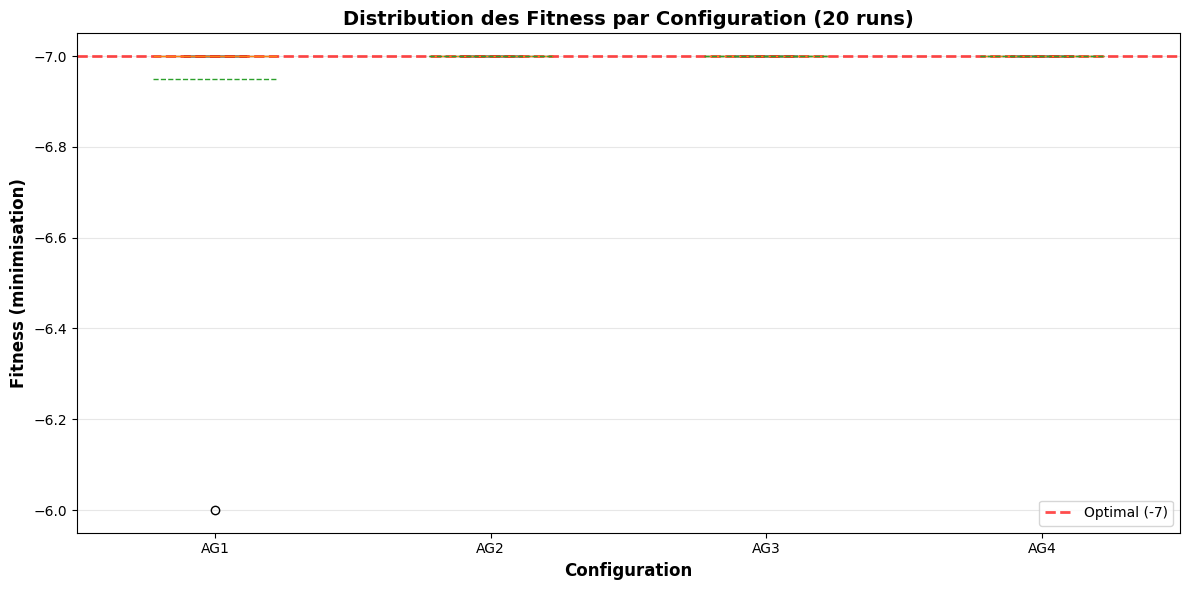


Boxplots générés avec succès


In [93]:
# Création des boxplots
fig, ax = plt.subplots(figsize=(12, 6))

# Préparation des données pour boxplot
data_for_boxplot = [results[c]['fitness_values'] for c in configurations.keys()]
labels = list(configurations.keys())

# Création des boxplots
bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,
                showmeans=True, meanline=True)

# Coloration des boîtes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Configuration du graphique
ax.set_ylabel('Fitness (minimisation)', fontsize=12, fontweight='bold')
ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Fitness par Configuration (20 runs)', 
             fontsize=14, fontweight='bold')
ax.axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', linewidth=2, 
           label=f'Optimal ({OPTIMAL_VALUE})', alpha=0.7)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=10)

# Inverser l'axe Y pour que l'optimal soit en haut
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nBoxplots générés avec succès")

### 7.3 Graphiques Comparatifs

/var/folders/mt/qtq70xcs705brjrxvtb5kmdr0000gn/T/ipykernel_4316/2352057906.py:75: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mt/qtq70xcs705brjrxvtb5kmdr0000gn/T/ipykernel_4316/2352057906.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/salimtitouche/Documents/m2-miage/qfd/FloatPairs/jmetalpy_env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


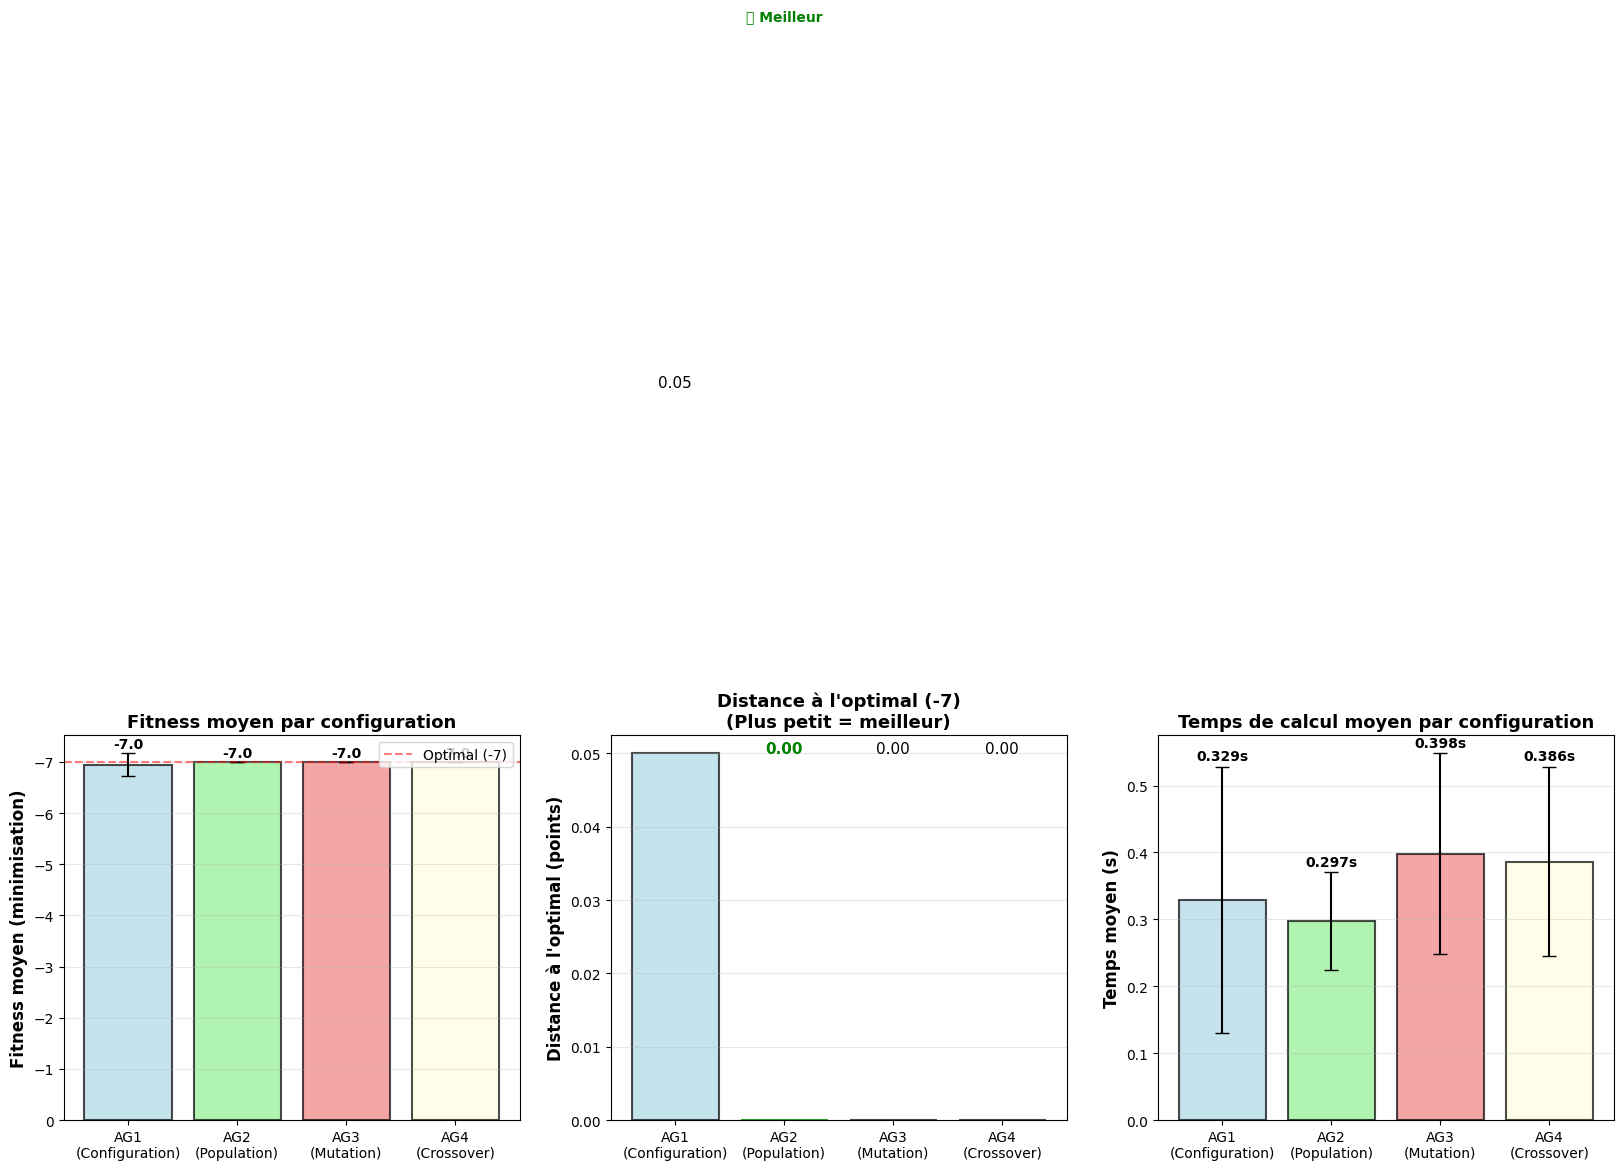


Graphiques complémentaires générés

ANALYSE DES DISTANCES À L'OPTIMAL
AG2 : 0.00 points de l'optimal
AG3 : 0.00 points de l'optimal
AG4 : 0.00 points de l'optimal
AG1 : 0.05 points de l'optimal


In [94]:
# Graphiques complémentaires : Moyenne + Distance + Temps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

configs = list(configurations.keys())
means = [results[c]['mean'] for c in configs]
stds = [results[c]['std'] for c in configs]
x_pos = np.arange(len(configs))

# Graphique 1 : Barres des moyennes avec écart-type
axes[0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
           color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[0].set_ylabel('Fitness moyen (minimisation)', fontsize=12, fontweight='bold')
axes[0].set_title('Fitness moyen par configuration', fontsize=13, fontweight='bold')

# Inverser l'axe Y
axes[0].invert_yaxis()

# Ligne de référence
axes[0].axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', alpha=0.5, 
                label=f'Optimal ({OPTIMAL_VALUE})')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend(loc='upper right')

# Ajout des valeurs sur les barres
for i, (m, s) in enumerate(zip(means, stds)):
    axes[0].text(i, m - s - 0.1, f'{m:.1f}', ha='center', fontsize=10, fontweight='bold')

# Graphique 2 : Distance à l'optimal
distances = [abs(OPTIMAL_VALUE - results[c]['mean']) for c in configs]

bars = axes[1].bar(x_pos, distances, alpha=0.7, color=colors,
                   edgecolor='black', linewidth=1.5)

# Mettre en vert la meilleure (distance la plus petite)
best_idx = distances.index(min(distances))
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(0.8)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[1].set_ylabel('Distance à l\'optimal (points)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distance à l\'optimal ({OPTIMAL_VALUE})\n(Plus petit = meilleur)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for i, d in enumerate(distances):
    color = 'green' if i == best_idx else 'black'
    weight = 'bold' if i == best_idx else 'normal'
    axes[1].text(i, d + 0.05, f'{d:.2f}', ha='center', fontsize=11, 
                fontweight=weight, color=color)

# Annotation pour le meilleur
axes[1].text(best_idx, distances[best_idx] + 0.15, '⭐ Meilleur', 
            ha='center', fontsize=10, color='green', fontweight='bold')

# Graphique 3 : Temps de calcul moyen
times = [results[c]['time_mean'] for c in configs]
time_stds = [results[c]['time_std'] for c in configs]

axes[2].bar(x_pos, times, yerr=time_stds, capsize=5, alpha=0.7,
           color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[2].set_ylabel('Temps moyen (s)', fontsize=12, fontweight='bold')
axes[2].set_title('Temps de calcul moyen par configuration', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for i, (t, ts) in enumerate(zip(times, time_stds)):
    axes[2].text(i, t + ts + 0.01, f'{t:.3f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nGraphiques complémentaires générés")
print("\n" + "="*60)
print("ANALYSE DES DISTANCES À L'OPTIMAL")
print("="*60)

# Afficher les distances triées
distances_with_names = [(configs[i], distances[i]) for i in range(len(configs))]
distances_with_names.sort(key=lambda x: x[1])

for i, (name, dist) in enumerate(distances_with_names, 1):
    print(f"{name} : {dist:.2f} points de l'optimal")

## 8. Analyse Détaillée

### 8.1 Comparaison des Configurations

In [95]:
print("="*80)
print("ANALYSE COMPARATIVE DES CONFIGURATIONS")
print("="*80)

# Classement par performance moyenne
ranking = sorted(results.items(), key=lambda x: x[1]['mean'])

print("\n1. CLASSEMENT PAR PERFORMANCE MOYENNE (fitness moyen):")
print("-" * 80)
for i, (config, res) in enumerate(ranking, 1):
    pairs = -res['mean']
    dist_optimal = abs(OPTIMAL_VALUE - res['mean'])
    print(f"{i}. {config} ({configurations[config]['nom']}):")
    print(f"   - Fitness moyen: {res['mean']:.2f} ({pairs:.2f} paires)")
    print(f"   - Distance à l'optimal: {dist_optimal:.2f} points")
    print(f"   - Écart-type: {res['std']:.2f}")
    print(f"   - Taux de succès: {res['success_rate']:.1f}%")
    print()

# Classement par taux de succès
ranking_success = sorted(results.items(), key=lambda x: x[1]['success_rate'], reverse=True)

print("\n2. CLASSEMENT PAR TAUX DE SUCCÈS (atteinte de l'optimal):")
print("-" * 80)
for i, (config, res) in enumerate(ranking_success, 1):
    print(f"{i}. {config}: {res['success_rate']:.1f}%")

# Classement par temps d'exécution
ranking_time = sorted(results.items(), key=lambda x: x[1]['time_mean'])

print("\n3. CLASSEMENT PAR TEMPS D'EXÉCUTION:")
print("-" * 80)
for i, (config, res) in enumerate(ranking_time, 1):
    print(f"{i}. {config}: {res['time_mean']:.4f}s (±{res['time_std']:.4f}s)")

print("\n" + "="*80)

ANALYSE COMPARATIVE DES CONFIGURATIONS

1. CLASSEMENT PAR PERFORMANCE MOYENNE (fitness moyen):
--------------------------------------------------------------------------------
1. AG2 (Population doublée):
   - Fitness moyen: -7.00 (7.00 paires)
   - Distance à l'optimal: 0.00 points
   - Écart-type: 0.00
   - Taux de succès: 100.0%

2. AG3 (Mutation index augmenté):
   - Fitness moyen: -7.00 (7.00 paires)
   - Distance à l'optimal: 0.00 points
   - Écart-type: 0.00
   - Taux de succès: 100.0%

3. AG4 (Crossover réduit):
   - Fitness moyen: -7.00 (7.00 paires)
   - Distance à l'optimal: 0.00 points
   - Écart-type: 0.00
   - Taux de succès: 100.0%

4. AG1 (Configuration Baseline):
   - Fitness moyen: -6.95 (6.95 paires)
   - Distance à l'optimal: 0.05 points
   - Écart-type: 0.22
   - Taux de succès: 95.0%


2. CLASSEMENT PAR TAUX DE SUCCÈS (atteinte de l'optimal):
--------------------------------------------------------------------------------
1. AG2: 100.0%
2. AG3: 100.0%
3. AG4: 100.

### 8.2 Influence des Paramètres

In [96]:
print("="*80)
print("ANALYSE DE L'INFLUENCE DES PARAMÈTRES")
print("="*80)

# Comparaison AG1 vs AG2 (effet de la population)
print("\n1. EFFET DE LA TAILLE DE POPULATION (AG1 vs AG2):")
print("-" * 80)
ag1_pairs = -results['AG1']['mean']
ag2_pairs = -results['AG2']['mean']
diff_pop = ag2_pairs - ag1_pairs
print(f"AG1 (pop=50): {ag1_pairs:.2f} paires")
print(f"AG2 (pop=100): {ag2_pairs:.2f} paires")
print(f"Différence: {diff_pop:+.2f} paires")
if diff_pop > 0:
    print("→ Doubler la population AMÉLIORE les résultats")
elif diff_pop < 0:
    print("→ Doubler la population DÉGRADE les résultats")
else:
    print("→ Pas d'effet significatif de la taille de population")

# Comparaison AG1 vs AG3 (effet de l'index de mutation)
print("\n2. EFFET DE L'INDEX DE MUTATION (AG1 vs AG3):")
print("-" * 80)
ag3_pairs = -results['AG3']['mean']
diff_mut = ag3_pairs - ag1_pairs
print(f"AG1 (mut_index=20): {ag1_pairs:.2f} paires")
print(f"AG3 (mut_index=80): {ag3_pairs:.2f} paires")
print(f"Différence: {diff_mut:+.2f} paires")
if diff_mut > 0:
    print("→ Augmenter l'index de mutation AMÉLIORE les résultats")
    print("   (mutations plus exploratoires)")
elif diff_mut < 0:
    print("→ Augmenter l'index de mutation DÉGRADE les résultats")
else:
    print("→ Pas d'effet significatif de l'index de mutation")

# Comparaison AG1 vs AG4 (effet du crossover)
print("\n3. EFFET DE LA PROBABILITÉ DE CROISEMENT (AG1 vs AG4):")
print("-" * 80)
ag4_pairs = -results['AG4']['mean']
diff_cross = ag4_pairs - ag1_pairs
print(f"AG1 (p_cross=0.9): {ag1_pairs:.2f} paires")
print(f"AG4 (p_cross=0.45): {ag4_pairs:.2f} paires")
print(f"Différence: {diff_cross:+.2f} paires")
if diff_cross > 0:
    print("→ Réduire le croisement AMÉLIORE les résultats")
    print("   (plus de diversité par mutation)")
elif diff_cross < 0:
    print("→ Réduire le croisement DÉGRADE les résultats")
else:
    print("→ Pas d'effet significatif de la probabilité de croisement")

print("\n" + "="*80)

ANALYSE DE L'INFLUENCE DES PARAMÈTRES

1. EFFET DE LA TAILLE DE POPULATION (AG1 vs AG2):
--------------------------------------------------------------------------------
AG1 (pop=50): 6.95 paires
AG2 (pop=100): 7.00 paires
Différence: +0.05 paires
→ Doubler la population AMÉLIORE les résultats

2. EFFET DE L'INDEX DE MUTATION (AG1 vs AG3):
--------------------------------------------------------------------------------
AG1 (mut_index=20): 6.95 paires
AG3 (mut_index=80): 7.00 paires
Différence: +0.05 paires
→ Augmenter l'index de mutation AMÉLIORE les résultats
   (mutations plus exploratoires)

3. EFFET DE LA PROBABILITÉ DE CROISEMENT (AG1 vs AG4):
--------------------------------------------------------------------------------
AG1 (p_cross=0.9): 6.95 paires
AG4 (p_cross=0.45): 7.00 paires
Différence: +0.05 paires
→ Réduire le croisement AMÉLIORE les résultats
   (plus de diversité par mutation)



## 9. Recommandations et Conclusions

In [97]:
print("="*80)
print("RECOMMANDATIONS ET CONCLUSIONS")
print("="*80)

# Identification de la meilleure configuration globale
best = min(results.items(), key=lambda x: x[1]['mean'])
best_config_name = best[0]
best_res = best[1]

print("\n🏆 MEILLEURE CONFIGURATION GLOBALE:")
print("-" * 80)
print(f"Configuration: {best_config_name}")
print(f"Description: {configurations[best_config_name]['nom']}")
print(f"\nParamètres:")
for key, value in configurations[best_config_name].items():
    if key != 'nom':
        print(f"  - {key}: {value}")
print(f"\nPerformances:")
print(f"  - Fitness moyen: {best_res['mean']:.2f} ({-best_res['mean']:.2f} paires)")
print(f"  - Distance à l'optimal: {abs(OPTIMAL_VALUE - best_res['mean']):.2f} points")
print(f"  - Taux de succès: {best_res['success_rate']:.1f}%")
print(f"  - Temps moyen: {best_res['time_mean']:.4f}s")

print("\n📊 OBSERVATIONS GÉNÉRALES:")
print("-" * 80)
print("1. Le problème FloatPairs est un problème de maximisation complexe")
print("2. L'optimal théorique (7 paires pour n=8) nécessite une alternance parfaite")
print("3. Les algorithmes génétiques explorent efficacement l'espace de recherche")
print("4. La configuration des opérateurs a un impact significatif sur la convergence")

print("\n💡 RECOMMANDATIONS POUR AMÉLIORER LES RÉSULTATS:")
print("-" * 80)
print("1. Augmenter le nombre d'évaluations pour une meilleure convergence")
print("2. Tester des opérateurs de mutation adaptés au problème")
print("3. Implémenter une initialisation intelligente (e.g., alternance de signes)")
print("4. Utiliser des stratégies d'élitisme pour préserver les bonnes solutions")
print("5. Considérer des algorithmes hybrides (AG + recherche locale)")

print("\n" + "="*80)
print("FIN DE L'ANALYSE")
print("="*80)

RECOMMANDATIONS ET CONCLUSIONS

🏆 MEILLEURE CONFIGURATION GLOBALE:
--------------------------------------------------------------------------------
Configuration: AG2
Description: Population doublée

Paramètres:
  - population_size: 100
  - offspring_population_size: 100
  - mutation_probability: 0.125
  - mutation_distribution_index: 20.0
  - crossover_probability: 0.9
  - crossover_distribution_index: 20.0

Performances:
  - Fitness moyen: -7.00 (7.00 paires)
  - Distance à l'optimal: 0.00 points
  - Taux de succès: 100.0%
  - Temps moyen: 0.2973s

📊 OBSERVATIONS GÉNÉRALES:
--------------------------------------------------------------------------------
1. Le problème FloatPairs est un problème de maximisation complexe
2. L'optimal théorique (7 paires pour n=8) nécessite une alternance parfaite
3. Les algorithmes génétiques explorent efficacement l'espace de recherche
4. La configuration des opérateurs a un impact significatif sur la convergence

💡 RECOMMANDATIONS POUR AMÉLIORER LES 

## 10. Export des Résultats

In [98]:
# Export des résultats en CSV
summary_df.to_csv('floatpairs_ag_results.csv', index=False)
print("✓ Résultats exportés dans 'floatpairs_ag_results.csv'")

# Export des données détaillées pour chaque configuration
for config_name, res in results.items():
    detailed_df = pd.DataFrame({
        'Run': range(1, N_RUNS + 1),
        'Fitness': res['fitness_values'],
        'Pairs': [-f for f in res['fitness_values']],
        'Execution_Time': res['execution_times']
    })
    filename = f'floatpairs_ag_{config_name}_detailed.csv'
    detailed_df.to_csv(filename, index=False)
    print(f"✓ Détails de {config_name} exportés dans '{filename}'")

print("\n✓ Tous les fichiers ont été exportés avec succès !")

✓ Résultats exportés dans 'floatpairs_ag_results.csv'
✓ Détails de AG1 exportés dans 'floatpairs_ag_AG1_detailed.csv'
✓ Détails de AG2 exportés dans 'floatpairs_ag_AG2_detailed.csv'
✓ Détails de AG3 exportés dans 'floatpairs_ag_AG3_detailed.csv'
✓ Détails de AG4 exportés dans 'floatpairs_ag_AG4_detailed.csv'

✓ Tous les fichiers ont été exportés avec succès !
